In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

%cd drive/My\ Drive/Independent\ Study/
!ls

/content/drive/My Drive/Independent Study
'=0.46.1'		      hellaswag_results.csv	   qwen.csv
 analysis_outputs	      predictions1.csv		   qwen_stable.csv
 confusion_matrices.png       predictions2.csv		   stable_zephyr.csv
 fingerprint_similarity.png   predictions_first10_hf.csv
 HellaSwagDataset.csv	      probe_size_accuracy.png


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# SECTION 1: DATA LOADING AND INITIAL SETUP

In [ ]:
# Load the dataset containing model predictions
# Expected columns: label, ending0-3, and prediction columns for each model
df = pd.read_csv('qwen_stable.csv')

# Define the model prediction columns
# Each model has a corresponding prediction column and correctness column
model_pred_cols = {
    "qwen_0.5b":        "qwen_0.5b_pred",
    "qwen_1.5b":        "qwen_1.5b_pred",
    "qwen_7b":          "qwen_7b_pred",
    "stable_zephyr_3b": "stable_zephyr_3b_pred",
    "stable2_1.6b":     "stable2_1.6b_pred",
    "stable2_12b":      "stable2_12b_pred",
}

# HellaSwag is a 4-way multiple choice task
n_classes = 4

# Check for invalid predictions (-1 values) and report them
print("=" * 80)
print("DATA QUALITY CHECK")
print("=" * 80)
for name, col in model_pred_cols.items():
    n_invalid = (df[col] == -1).sum()
    pct_invalid = 100 * n_invalid / len(df)
    if n_invalid > 0:
        print(f"{name:20s}: {n_invalid:4d} invalid predictions ({pct_invalid:.2f}%)")
print()

DATA QUALITY CHECK
qwen_1.5b           :    1 invalid predictions (0.01%)
stable_zephyr_3b    :    2 invalid predictions (0.02%)
stable2_1.6b        :  790 invalid predictions (7.87%)
stable2_12b         :  267 invalid predictions (2.66%)



# SECTION 2: TRAIN/TEST SPLIT

In [ ]:
# Split data into train (80%) and test (20%) sets
# IMPORTANT: We'll compute fingerprints ONLY on training data to avoid leakage
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print()

Training set size: 8033
Test set size: 2009



# SECTION 3: CONFUSION MATRIX FINGERPRINTING

In [ ]:
def confusion_hist(gold_labels, pred_labels, n_classes=4):
    """
    Compute a confusion matrix and return it as a normalized histogram.

    This creates a 'fingerprint' of a model's error patterns:
    - Diagonal elements = correct predictions
    - Off-diagonal = specific confusion patterns (e.g., predicting 2 when truth is 0)

    Args:
        gold_labels: Ground truth labels
        pred_labels: Model predictions
        n_classes: Number of classes (4 for HellaSwag)

    Returns:
        v: Flattened, normalized confusion histogram (16-d for 4 classes)
        conf: Raw confusion matrix (4x4)
    """
    # Initialize confusion matrix
    conf = np.zeros((n_classes, n_classes), dtype=np.int64)

    # Populate confusion matrix
    # conf[i,j] = number of times true label was i and prediction was j
    for g, p in zip(gold_labels, pred_labels):
        if 0 <= g < n_classes and 0 <= p < n_classes:
            conf[g, p] += 1

    # Flatten and normalize to create a probability distribution
    # This is the model's "fingerprint"
    v = conf.flatten().astype(np.float32)
    v /= v.sum() + 1e-8  # Add epsilon to avoid division by zero

    return v, conf

# Compute fingerprints for each model using ONLY training data
print("=" * 80)
print("COMPUTING MODEL FINGERPRINTS (on training data only)")
print("=" * 80)

train_gold = train_df["label"].to_numpy()
fingerprints = {}      # Normalized 16-d vectors
conf_mats = {}         # Raw 4x4 confusion matrices

for name, col in model_pred_cols.items():
    train_pred = train_df[col].to_numpy()
    v, cm = confusion_hist(train_gold, train_pred, n_classes)
    fingerprints[name] = v
    conf_mats[name] = cm

    # Display the confusion matrix as a 4x4 grid
    print(f"\n{name} confusion fingerprint:")
    print(f"Accuracy: {cm.diagonal().sum() / cm.sum():.3f}")
    print("Normalized confusion matrix (rows=true, cols=pred):")
    print(v.reshape(4, 4))

print()


COMPUTING MODEL FINGERPRINTS (on training data only)

qwen_0.5b confusion fingerprint:
Accuracy: 0.253
Normalized confusion matrix (rows=true, cols=pred):
[[0.07357152 0.02639114 0.05128843 0.10108303]
 [0.06660027 0.02452384 0.05751276 0.09896676]
 [0.07145525 0.02651562 0.05539649 0.10207892]
 [0.06722271 0.02365243 0.05452508 0.09921574]]

qwen_1.5b confusion fingerprint:
Accuracy: 0.257
Normalized confusion matrix (rows=true, cols=pred):
[[0.01307271 0.11466634 0.07358067 0.05104582]
 [0.00087151 0.07221115 0.11217629 0.0623755 ]
 [0.00510458 0.08378984 0.10333665 0.06324701]
 [0.00423307 0.07880976 0.093252   0.06822709]]

qwen_7b confusion fingerprint:
Accuracy: 0.409
Normalized confusion matrix (rows=true, cols=pred):
[[0.15909374 0.06373709 0.01805054 0.01145276]
 [0.02190962 0.05514752 0.10021163 0.07033487]
 [0.07070833 0.0313706  0.11029503 0.04307233]
 [0.06896552 0.03460725 0.05614341 0.08489979]]

stable_zephyr_3b confusion fingerprint:
Accuracy: 0.303
Normalized confusio

# SECTION 4: LOGISTIC REGRESSION CLASSIFICATION (IMPROVED)

In [ ]:
print("=" * 80)
print("LOGISTIC REGRESSION: PREDICT MODEL FROM CONFUSION FINGERPRINT")
print("=" * 80)

# Create a mapping from model names to integer IDs
system_names = list(model_pred_cols.keys())
system_ids = {name: idx for idx, name in enumerate(system_names)}

# Build dataset: each sample is a model's prediction on one item
# Feature: 16-d one-hot encoding of the (gold, pred) pair
# Label: which model made this prediction
X_lr = []
y_lr = []

for name, col in model_pred_cols.items():
    sid = system_ids[name]
    gold_all = train_df["label"].to_numpy()
    pred_all = train_df[col].to_numpy()

    for g, p in zip(gold_all, pred_all):
        # Skip invalid predictions
        if not (0 <= g < n_classes and 0 <= p < n_classes):
            continue

        # Create one-hot encoding: position k=1 where k = 4*gold + pred
        k = n_classes * g + p
        vec = np.zeros(n_classes * n_classes, dtype=np.float32)
        vec[k] = 1.0

        X_lr.append(vec)
        y_lr.append(sid)

X_lr = np.stack(X_lr)
y_lr = np.array(y_lr)

# Split into train/test for the logistic regression task
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(
    X_lr, y_lr, test_size=0.2, random_state=42, stratify=y_lr
)

# Train logistic regression classifier
clf = LogisticRegression(max_iter=1000, multi_class="multinomial")
clf.fit(X_lr_train, y_lr_train)

# Evaluate
y_lr_pred = clf.predict(X_lr_test)
print("\nClassification Report (per-prediction model identification):")
print(classification_report(y_lr_test, y_lr_pred, digits=3, target_names=system_names))
print()

LOGISTIC REGRESSION: PREDICT MODEL FROM CONFUSION FINGERPRINT


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Classification Report (per-prediction model identification):
                  precision    recall  f1-score   support

       qwen_0.5b      0.215     0.192     0.203      1607
       qwen_1.5b      0.278     0.271     0.274      1606
         qwen_7b      0.275     0.116     0.163      1607
stable_zephyr_3b      0.375     0.418     0.395      1606
    stable2_1.6b      0.321     0.356     0.338      1479
     stable2_12b      0.366     0.550     0.439      1565

        accuracy                          0.316      9470
       macro avg      0.305     0.317     0.302      9470
    weighted avg      0.304     0.316     0.301      9470




# SECTION 5: FINGERPRINT-BASED MODEL IDENTIFICATION (COSINE SIMILARITY)

In [ ]:
print("=" * 80)
print("FINGERPRINT-BASED IDENTIFICATION: COSINE SIMILARITY APPROACH")
print("=" * 80)

# Stack all reference fingerprints into a matrix
family_matrix = np.stack([fingerprints[name] for name in system_names])  # (6, 16)

# Get test set ground truth
test_gold = test_df["label"].to_numpy()

def identify_family(sub_gold, sub_pred):
    """
    Identify which model family produced these predictions.

    Method:
    1. Compute confusion fingerprint for the subset
    2. Calculate cosine similarity with each reference fingerprint
    3. Return the model with highest similarity

    Args:
        sub_gold: Subset of ground truth labels
        sub_pred: Subset of predictions

    Returns:
        best_family: Name of most similar model
        sims: Similarity scores for all models
    """
    v, _ = confusion_hist(sub_gold, sub_pred, n_classes)
    v = v.reshape(1, -1)

    # Compute cosine similarity with each reference fingerprint
    sims = cosine_similarity(v, family_matrix)[0]
    best_idx = np.argmax(sims)

    return system_names[best_idx], sims

FINGERPRINT-BASED IDENTIFICATION: COSINE SIMILARITY APPROACH


# SECTION 6: PROBE SIZE EXPERIMENTS

In [ ]:
print("\nEvaluating identification accuracy vs. probe set size...")
print("(Testing on held-out test set)\n")

rng = np.random.default_rng(0)

def eval_probe_size(model_name, n_probe=20, n_trials=100):
    """
    Evaluate how many samples are needed to identify a model.

    Args:
        model_name: Name of the model to test
        n_probe: Number of samples to use for identification
        n_trials: Number of random trials to average over

    Returns:
        Accuracy: proportion of trials where model was correctly identified
    """
    correct = 0
    full_test_pred = test_df[model_pred_cols[model_name]].to_numpy()
    n_items_test = len(test_df)

    for _ in range(n_trials):
        # Sample random subset of test predictions
        idx = rng.choice(n_items_test, size=n_probe, replace=False)
        sub_gold = test_gold[idx]
        sub_pred = full_test_pred[idx]

        # Identify model based on this subset
        identified_family, _ = identify_family(sub_gold, sub_pred)

        if identified_family == model_name:
            correct += 1

    return correct / n_trials

# Test various probe sizes
probe_sizes = [5, 10, 20, 50, 100]
results = {}

for model_name in system_names:
    results[model_name] = []
    print(f"\n{model_name}:")
    for n_probe in probe_sizes:
        acc = eval_probe_size(model_name, n_probe=n_probe, n_trials=100)
        results[model_name].append(acc)
        print(f"  {n_probe:3d} probes: {acc:.3f} accuracy")

print()



Evaluating identification accuracy vs. probe set size...
(Testing on held-out test set)


qwen_0.5b:
    5 probes: 0.430 accuracy
   10 probes: 0.600 accuracy
   20 probes: 0.740 accuracy
   50 probes: 0.960 accuracy
  100 probes: 1.000 accuracy

qwen_1.5b:
    5 probes: 0.600 accuracy
   10 probes: 0.630 accuracy
   20 probes: 0.710 accuracy
   50 probes: 0.870 accuracy
  100 probes: 0.910 accuracy

qwen_7b:
    5 probes: 0.450 accuracy
   10 probes: 0.650 accuracy
   20 probes: 0.870 accuracy
   50 probes: 0.980 accuracy
  100 probes: 1.000 accuracy

stable_zephyr_3b:
    5 probes: 0.520 accuracy
   10 probes: 0.680 accuracy
   20 probes: 0.750 accuracy
   50 probes: 0.810 accuracy
  100 probes: 0.880 accuracy

stable2_1.6b:
    5 probes: 0.530 accuracy
   10 probes: 0.670 accuracy
   20 probes: 0.880 accuracy
   50 probes: 0.950 accuracy
  100 probes: 1.000 accuracy

stable2_12b:
    5 probes: 0.730 accuracy
   10 probes: 0.870 accuracy
   20 probes: 0.990 accuracy
   50 probes: 1.

# SECTION 7: VISUALIZATION

CREATING VISUALIZATIONS
Saved: confusion_matrices.png
Saved: probe_size_accuracy.png
Saved: fingerprint_similarity.png



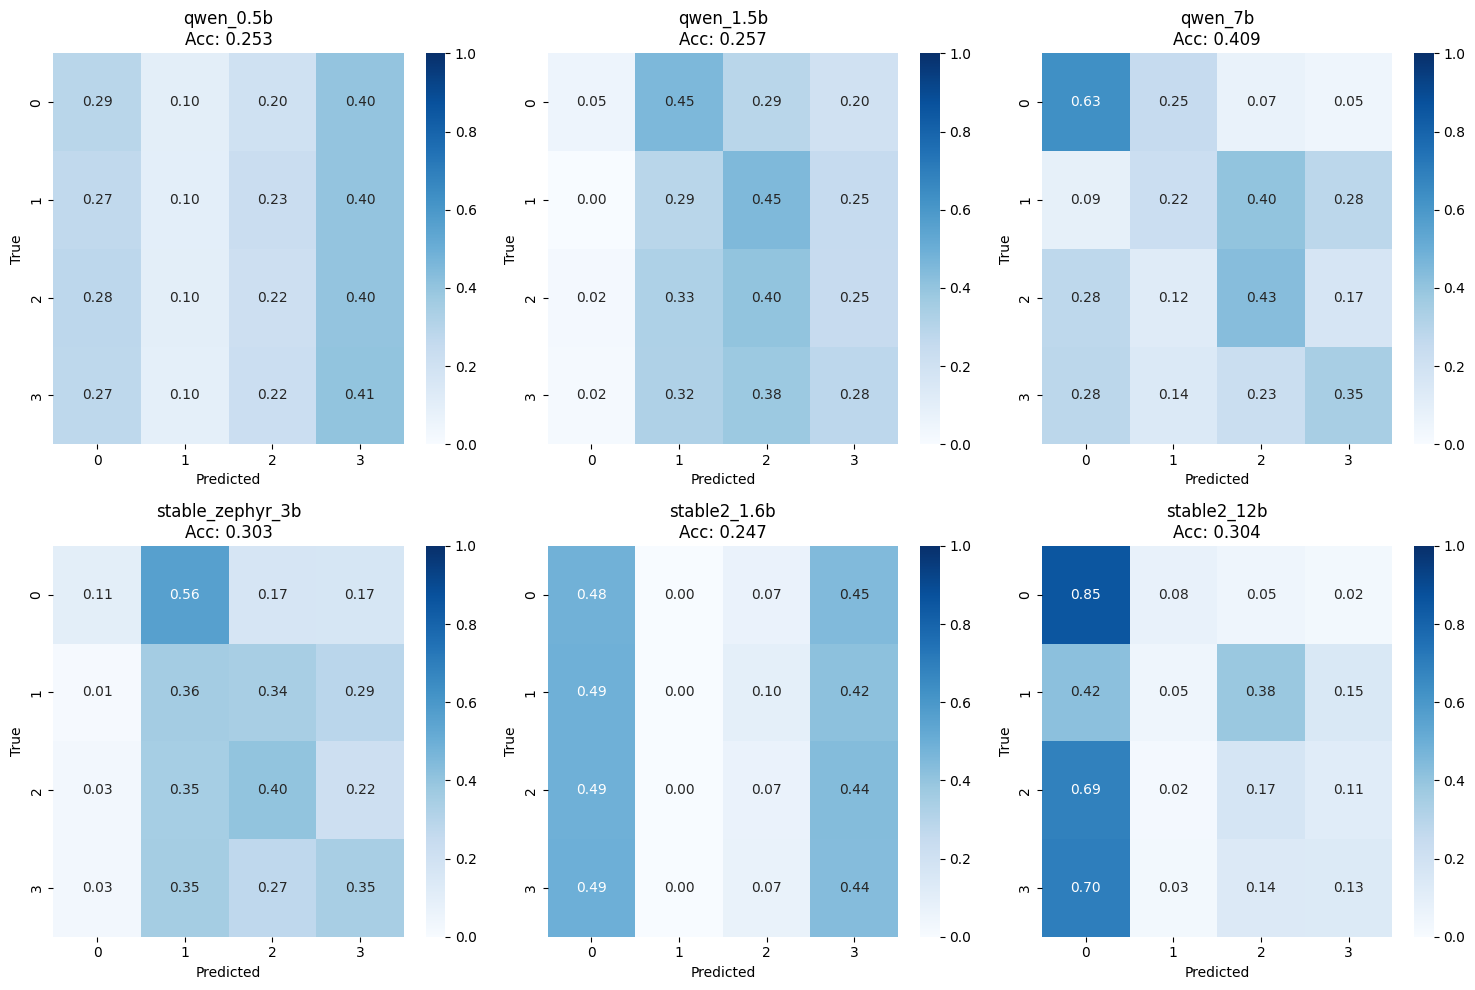

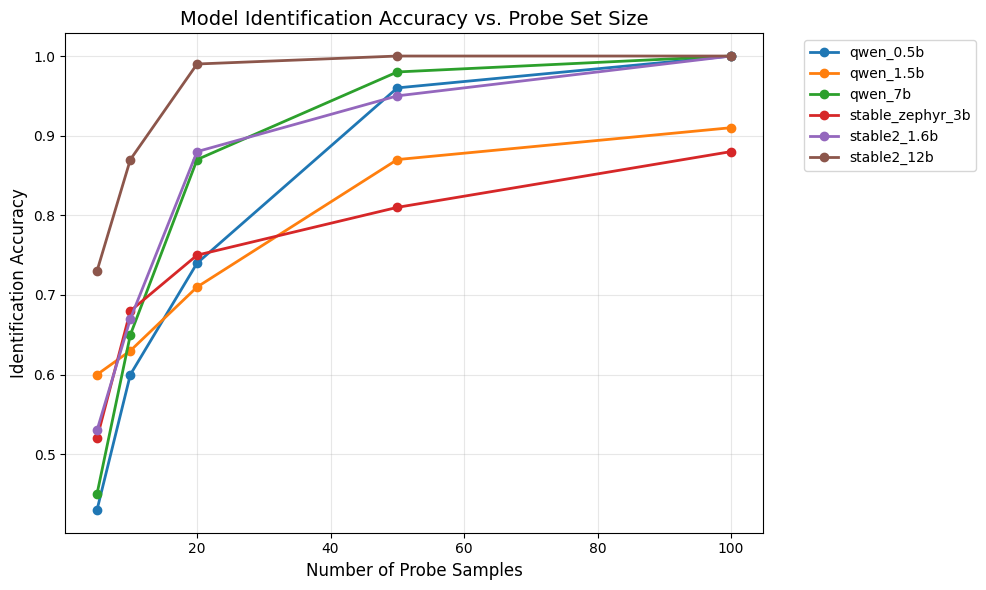

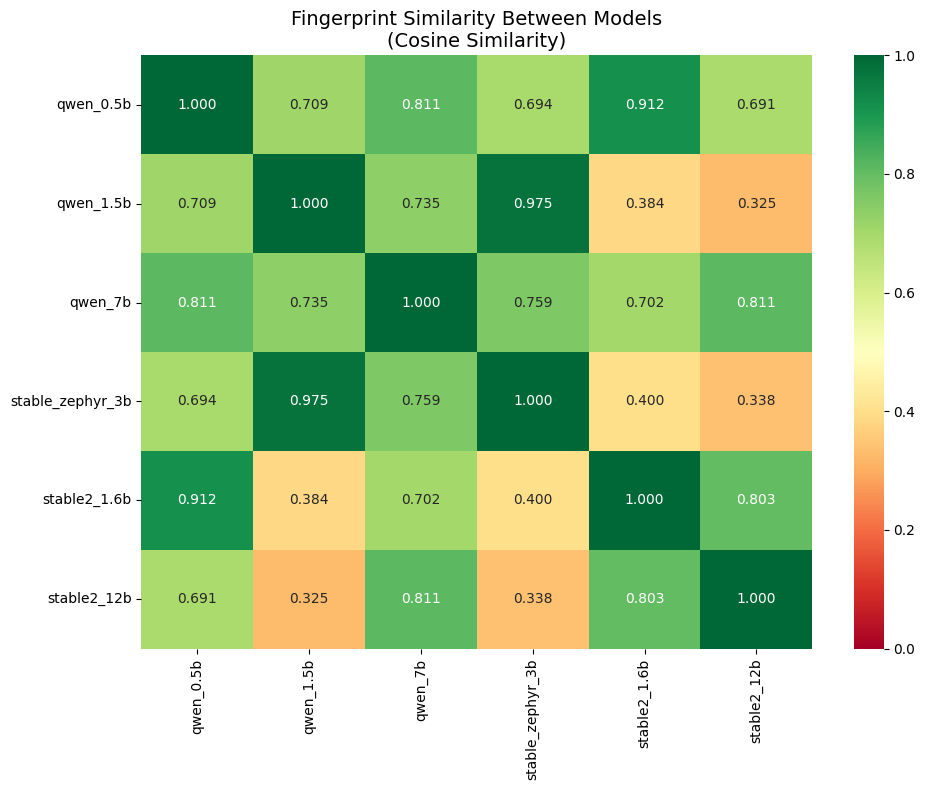

In [ ]:
print("=" * 80)
print("CREATING VISUALIZATIONS")
print("=" * 80)

# Plot 1: Confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, cm) in enumerate(conf_mats.items()):
    # Normalize by row (true label) to show distribution of predictions
    cm_norm = cm.astype(float)
    row_sums = cm_norm.sum(axis=1, keepdims=True)
    cm_norm = cm_norm / (row_sums + 1e-8)

    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                ax=axes[idx], cbar=True, vmin=0, vmax=1)
    axes[idx].set_title(f'{name}\nAcc: {cm.diagonal().sum()/cm.sum():.3f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
print("Saved: confusion_matrices.png")

# Plot 2: Probe size vs. accuracy
plt.figure(figsize=(10, 6))
for model_name, accs in results.items():
    plt.plot(probe_sizes, accs, marker='o', label=model_name, linewidth=2)

plt.xlabel('Number of Probe Samples', fontsize=12)
plt.ylabel('Identification Accuracy', fontsize=12)
plt.title('Model Identification Accuracy vs. Probe Set Size', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('probe_size_accuracy.png', dpi=150, bbox_inches='tight')
print("Saved: probe_size_accuracy.png")

# Plot 3: Fingerprint similarity heatmap
similarity_matrix = cosine_similarity(family_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=system_names, yticklabels=system_names,
            vmin=0, vmax=1, center=0.5)
plt.title('Fingerprint Similarity Between Models\n(Cosine Similarity)', fontsize=14)
plt.tight_layout()
plt.savefig('fingerprint_similarity.png', dpi=150, bbox_inches='tight')
print("Saved: fingerprint_similarity.png")

print()

# SECTION 8: SUMMARY STATISTICS

In [ ]:
print("=" * 80)
print("SUMMARY")
print("=" * 80)

print("\nModel Accuracies on Test Set:")
for name, col in model_pred_cols.items():
    test_pred = test_df[col].to_numpy()
    mask = (test_pred >= 0) & (test_pred < n_classes)
    if mask.sum() > 0:
        acc = (test_gold[mask] == test_pred[mask]).mean()
        print(f"  {name:20s}: {acc:.3f}")

print("\nKey Findings:")
print(f"  • Logistic Regression (per-item): {accuracy_score(y_lr_test, y_lr_pred):.3f} accuracy")
print(f"  • Fingerprint method with 20 probes: {np.mean([results[m][2] for m in system_names]):.3f} avg accuracy")
print(f"  • Fingerprint method with 100 probes: {np.mean([results[m][4] for m in system_names]):.3f} avg accuracy")
print("\n" + "=" * 80)

SUMMARY

Model Accuracies on Test Set:
  qwen_0.5b           : 0.271
  qwen_1.5b           : 0.262
  qwen_7b             : 0.413
  stable_zephyr_3b    : 0.316
  stable2_1.6b        : 0.245
  stable2_12b         : 0.297

Key Findings:
  • Logistic Regression (per-item): 0.316 accuracy
  • Fingerprint method with 20 probes: 0.823 avg accuracy
  • Fingerprint method with 100 probes: 0.965 avg accuracy



## APROACH 2: BEHAVIOURAL FINGERPRINTS

In [ ]:

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram



# STEP 1: Build Behavioral Fingerprints


In [ ]:


def build_behavioral_fingerprints(df):
    """
    Build behavioral fingerprints for all models in the dataframe.

    Returns:
        bf_dict: Dictionary mapping model names to fingerprint vectors
        bf_mat: Matrix of shape (n_models, n_features)
        model_names: List of model names
    """
    gold = df["label"].to_numpy()
    n_classes = 4

    model_pred_cols = {
        "qwen_0.5b":        "qwen_0.5b_pred",
        "qwen_1.5b":        "qwen_1.5b_pred",
        "qwen_7b":          "qwen_7b_pred",
        "stable_zephyr_3b": "stable_zephyr_3b_pred",
        "stable2_1.6b":     "stable2_1.6b_pred",
        "stable2_12b":      "stable2_12b_pred",
    }
    model_correct_cols = {
        "qwen_0.5b":        "qwen_0.5b_correct",
        "qwen_1.5b":        "qwen_1.5b_correct",
        "qwen_7b":          "qwen_7b_correct",
        "stable_zephyr_3b": "stable_zephyr_3b_correct",
        "stable2_1.6b":     "stable2_1.6b_correct",
        "stable2_12b":      "stable2_12b_correct",
    }

    model_names = list(model_pred_cols.keys())
    n_models = len(model_names)

    # Precompute prediction and correctness matrices
    pred_matrix = np.stack([df[col].to_numpy() for col in model_pred_cols.values()])
    correct_matrix = np.stack([df[col].to_numpy().astype(bool) for col in model_correct_cols.values()])
    n_items = pred_matrix.shape[1]

    # Item difficulty: fraction of models that get the item wrong
    item_difficulty = 1.0 - correct_matrix.mean(axis=0)

    # Agreement count per (model, item)
    agreement_count = np.zeros_like(pred_matrix, dtype=np.int32)
    for m in range(n_models):
        for i in range(n_items):
            agreement_count[m, i] = int((pred_matrix[:, i] == pred_matrix[m, i]).sum())

    def behavioral_fingerprint_for_model(m_index):
        """Build a 19-dim behavioral fingerprint for model m_index."""
        preds = pred_matrix[m_index]
        correct = correct_matrix[m_index]
        agrees = agreement_count[m_index]

        per_item_feats = []
        for i, (g, p) in enumerate(zip(gold, preds)):
            if not (0 <= g < n_classes and 0 <= p < n_classes):
                continue
            # Confusion one-hot
            k = n_classes * g + p
            conf_vec = np.zeros(n_classes * n_classes, dtype=np.float32)
            conf_vec[k] = 1.0

            feat = np.concatenate([
                np.array([float(correct[i])], dtype=np.float32),
                conf_vec,
                np.array([item_difficulty[i]], dtype=np.float32),
                np.array([agrees[i]], dtype=np.float32),
            ])
            per_item_feats.append(feat)

        per_item_feats = np.stack(per_item_feats)
        return per_item_feats.mean(axis=0)

    # Build fingerprints for all models
    bfingerprints = {}
    for m, name in enumerate(model_names):
        bfingerprints[name] = behavioral_fingerprint_for_model(m)

    bf_mat = np.stack([bfingerprints[name] for name in model_names])

    return bfingerprints, bf_mat, model_names



# STEP 2: PCA Analysis


In [ ]:
def perform_pca_analysis(bf_mat, model_names, n_components=2):
    """
    Perform PCA on behavioral fingerprints.

    Returns:
        pca: Fitted PCA object
        bf_pca: Transformed data
        bf_mat_norm: Normalized fingerprint matrix
    """
    # L2 normalize
    bf_mat_norm = normalize(bf_mat, norm="l2")

    # Fit PCA
    pca = PCA(n_components=n_components, random_state=42)
    bf_pca = pca.fit_transform(bf_mat_norm)

    print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
    print(f"Total Variance Explained: {pca.explained_variance_ratio_.sum():.3f}")

    return pca, bf_pca, bf_mat_norm


# STEP 3: Clustering Analysis


In [ ]:

def perform_clustering(bf_mat_norm, model_names, n_clusters=2):
    """
    Perform K-means and hierarchical clustering.

    Returns:
        kmeans_labels: K-means cluster assignments
        hierarchical_labels: Hierarchical cluster assignments
        silhouette_kmeans: Silhouette score for K-means
        silhouette_hierarchical: Silhouette score for hierarchical
    """
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(bf_mat_norm)
    silhouette_kmeans = silhouette_score(bf_mat_norm, kmeans_labels)

    # Hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    hierarchical_labels = hierarchical.fit_predict(bf_mat_norm)
    silhouette_hierarchical = silhouette_score(bf_mat_norm, hierarchical_labels)

    print(f"\nK-means Silhouette Score: {silhouette_kmeans:.3f}")
    print(f"Hierarchical Silhouette Score: {silhouette_hierarchical:.3f}")

    # Print cluster assignments
    print("\nK-means Cluster Assignments:")
    for model, label in zip(model_names, kmeans_labels):
        print(f"  {model}: Cluster {label}")

    print("\nHierarchical Cluster Assignments:")
    for model, label in zip(model_names, hierarchical_labels):
        print(f"  {model}: Cluster {label}")

    return kmeans_labels, hierarchical_labels, silhouette_kmeans, silhouette_hierarchical


def find_optimal_clusters(bf_mat_norm, max_clusters=5):
    """Find optimal number of clusters using elbow method and silhouette scores."""
    inertias = []
    silhouettes = []
    K_range = range(2, max_clusters + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(bf_mat_norm)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(bf_mat_norm, labels))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(K_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
    ax1.set_title('Elbow Method')
    ax1.grid(True, alpha=0.3)

    ax2.plot(K_range, silhouettes, 'ro-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    optimal_k = K_range[np.argmax(silhouettes)]
    print(f"\nOptimal number of clusters (by silhouette): {optimal_k}")

    return optimal_k





# STEP 4: Visualization


In [ ]:

def plot_pca_projection(bf_pca, model_names, labels=None, title="PCA Projection"):
    """Plot 2D PCA projection with optional cluster coloring."""
    plt.figure(figsize=(10, 8))

    if labels is not None:
        unique_labels = np.unique(labels)
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))

        for i, label in enumerate(unique_labels):
            mask = labels == label
            plt.scatter(bf_pca[mask, 0], bf_pca[mask, 1],
                       c=[colors[i]], label=f'Cluster {label}',
                       s=200, alpha=0.6, edgecolors='black', linewidth=2)
        plt.legend()
    else:
        plt.scatter(bf_pca[:, 0], bf_pca[:, 1],
                   s=200, alpha=0.6, edgecolors='black', linewidth=2)

    # Add model name labels
    for i, name in enumerate(model_names):
        plt.annotate(name, (bf_pca[i, 0], bf_pca[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=10, fontweight='bold')

    plt.xlabel(f'PC1', fontsize=12)
    plt.ylabel(f'PC2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_dendrogram(bf_mat_norm, model_names):
    """Plot hierarchical clustering dendrogram."""
    plt.figure(figsize=(12, 6))

    # Compute linkage
    linkage_matrix = linkage(bf_mat_norm, method='ward')

    # Plot dendrogram
    dendrogram(linkage_matrix, labels=model_names, leaf_font_size=12)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_similarity_heatmap(bf_mat_norm, model_names):
    """Plot cosine similarity heatmap."""
    from sklearn.metrics.pairwise import cosine_similarity

    sim_matrix = cosine_similarity(bf_mat_norm)

    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix,
                xticklabels=model_names,
                yticklabels=model_names,
                annot=True,
                fmt='.3f',
                cmap='RdYlGn',
                center=0.9,
                vmin=0.8,
                vmax=1.0,
                square=True,
                linewidths=0.5)
    plt.title('Behavioral Fingerprint Cosine Similarity', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_3d_pca(bf_mat_norm, model_names, labels=None):
    """Plot 3D PCA projection."""
    from mpl_toolkits.mplot3d import Axes3D

    pca_3d = PCA(n_components=3, random_state=42)
    bf_pca_3d = pca_3d.fit_transform(bf_mat_norm)

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    if labels is not None:
        unique_labels = np.unique(labels)
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))

        for i, label in enumerate(unique_labels):
            mask = labels == label
            ax.scatter(bf_pca_3d[mask, 0], bf_pca_3d[mask, 1], bf_pca_3d[mask, 2],
                      c=[colors[i]], label=f'Cluster {label}',
                      s=200, alpha=0.6, edgecolors='black', linewidth=2)
        ax.legend()
    else:
        ax.scatter(bf_pca_3d[:, 0], bf_pca_3d[:, 1], bf_pca_3d[:, 2],
                  s=200, alpha=0.6, edgecolors='black', linewidth=2)

    # Add labels
    for i, name in enumerate(model_names):
        ax.text(bf_pca_3d[i, 0], bf_pca_3d[i, 1], bf_pca_3d[i, 2], name,
               fontsize=10, fontweight='bold')

    ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})', fontsize=12)
    ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})', fontsize=12)
    ax.set_title('3D PCA Projection of Behavioral Fingerprints', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# MAIN EXECUTION


BEHAVIORAL FINGERPRINTING + PCA + CLUSTERING ANALYSIS

[1/5] Building behavioral fingerprints...
Built fingerprints for 6 models
Fingerprint dimension: 19

[2/5] Performing PCA...
PCA Explained Variance Ratio: [0.6685339 0.2516219]
Total Variance Explained: 0.920

[3/5] Finding optimal number of clusters...


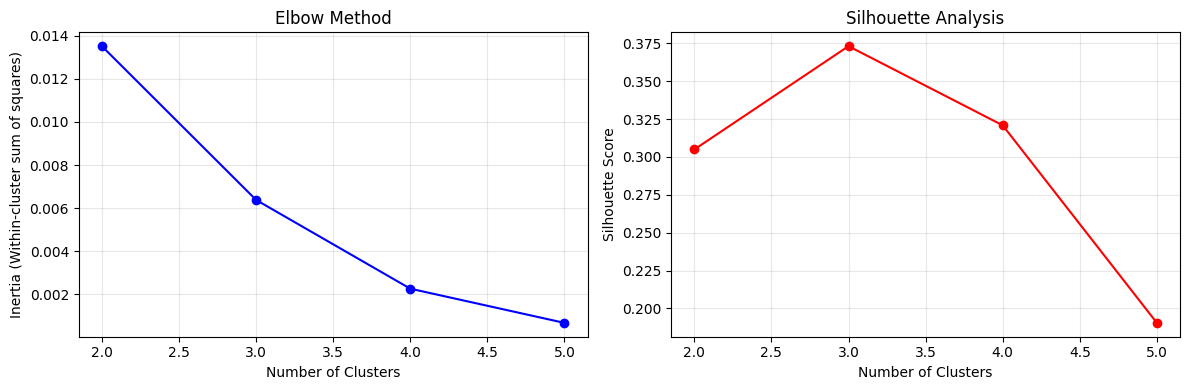


Optimal number of clusters (by silhouette): 3

[4/5] Performing clustering with k=2...

K-means Silhouette Score: 0.305
Hierarchical Silhouette Score: 0.359

K-means Cluster Assignments:
  qwen_0.5b: Cluster 1
  qwen_1.5b: Cluster 0
  qwen_7b: Cluster 0
  stable_zephyr_3b: Cluster 0
  stable2_1.6b: Cluster 1
  stable2_12b: Cluster 1

Hierarchical Cluster Assignments:
  qwen_0.5b: Cluster 0
  qwen_1.5b: Cluster 1
  qwen_7b: Cluster 0
  stable_zephyr_3b: Cluster 1
  stable2_1.6b: Cluster 0
  stable2_12b: Cluster 0

[5/5] Generating visualizations...


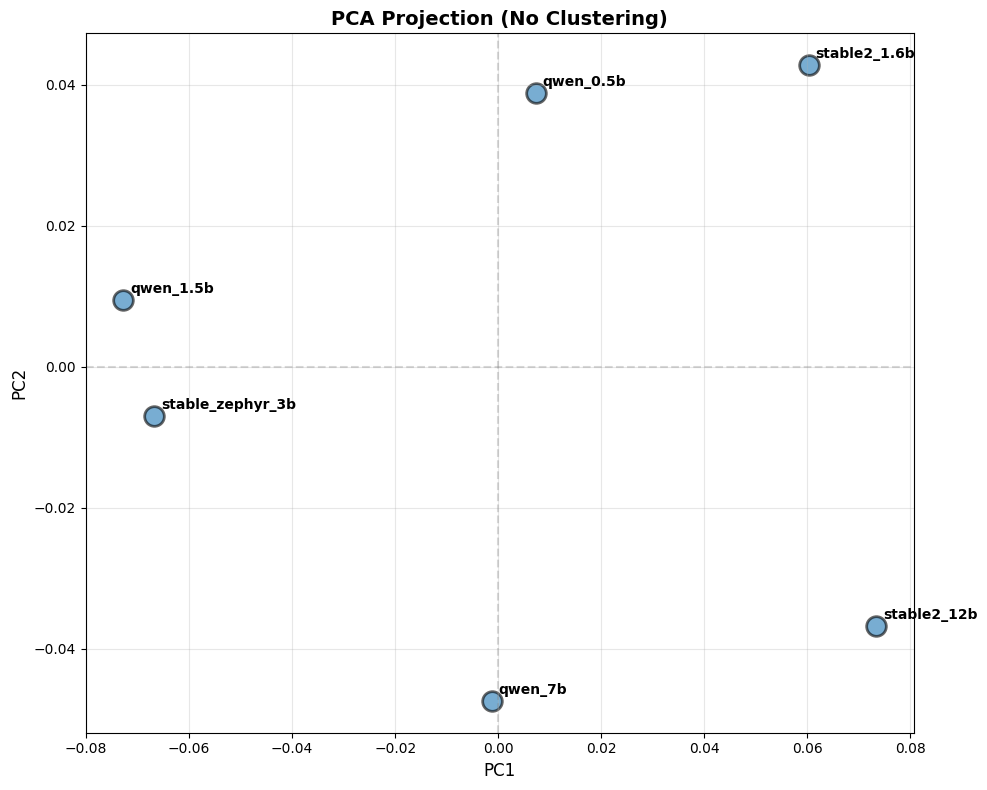

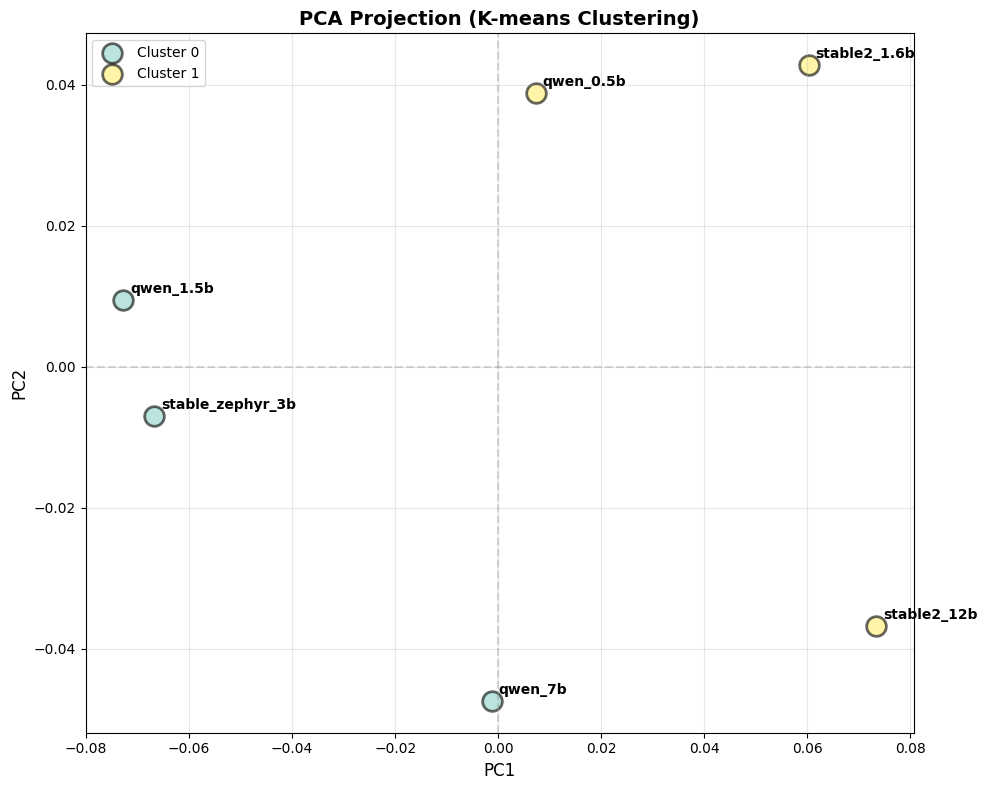

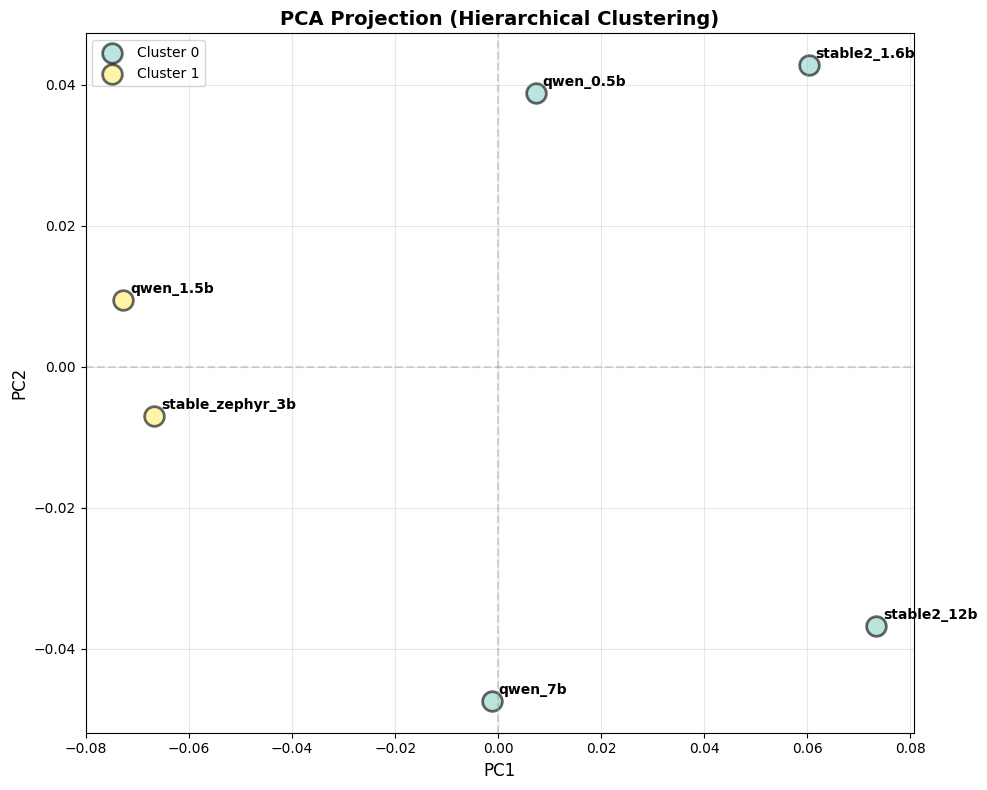

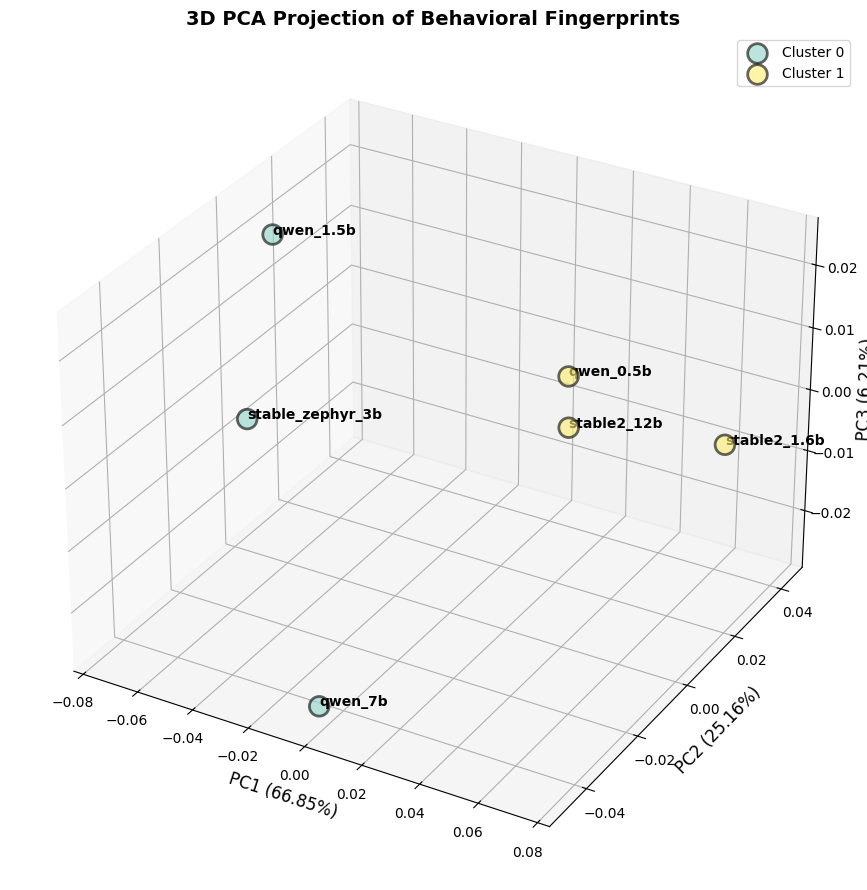

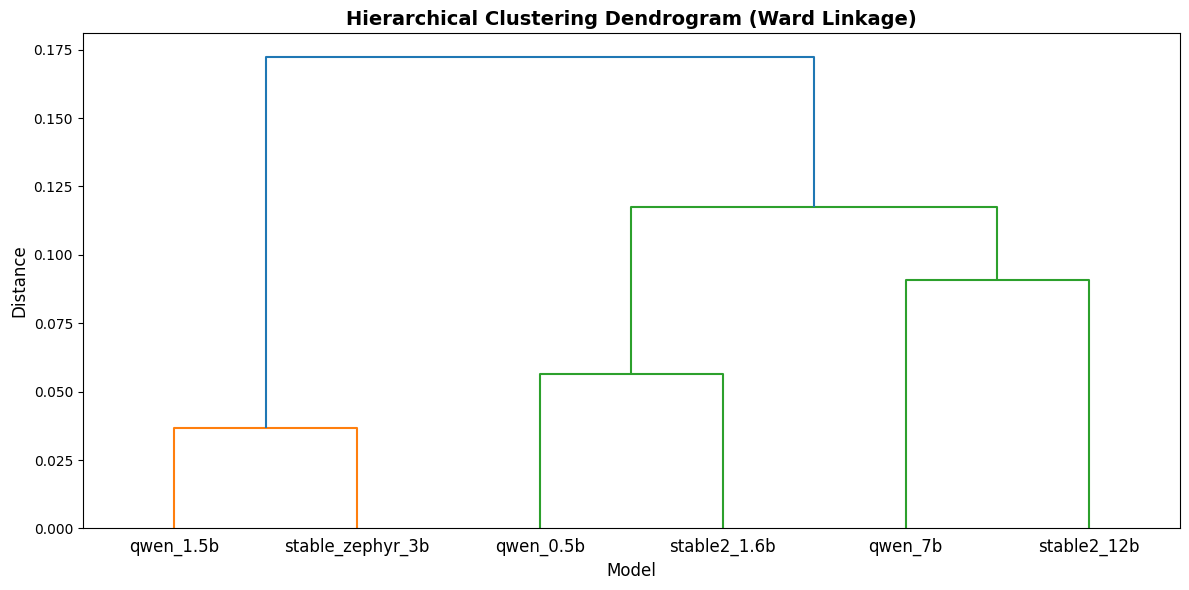

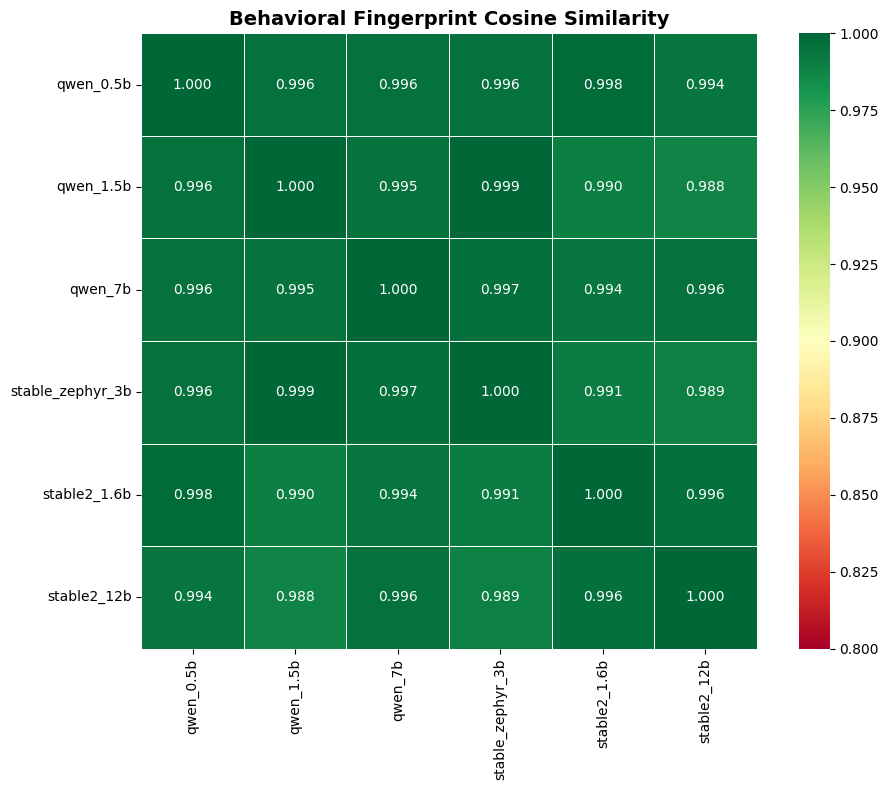


ANALYSIS COMPLETE


{'fingerprints': {'qwen_0.5b': array([0.25632343, 0.07498506, 0.0250946 , 0.05048795, 0.0998805 ,
         0.06731727, 0.02439753, 0.05656244, 0.09918343, 0.07000598,
         0.02619   , 0.05775742, 0.10336586, 0.06731727, 0.02489544,
         0.05337582, 0.09918343, 0.7081143 , 2.2991436 ], dtype=float32),
  'qwen_1.5b': array([2.5784284e-01, 1.2847326e-02, 1.1204063e-01, 7.4892938e-02,
         5.0692163e-02, 1.1951001e-03, 7.2403148e-02, 1.1243900e-01,
         6.1448064e-02, 4.7804005e-03, 8.4752515e-02, 1.0357534e-01,
         6.4236633e-02, 4.1828505e-03, 8.0071703e-02, 9.1425158e-02,
         6.9017030e-02, 7.0810181e-01, 2.2902102e+00], dtype=float32),
  'qwen_7b': array([0.41007766, 0.15933082, 0.06193985, 0.01842262, 0.01075483,
         0.0218084 , 0.05467039, 0.10276838, 0.0682135 , 0.07060347,
         0.03246365, 0.1113324 , 0.04291974, 0.06910974, 0.03445529,
         0.05646285, 0.08474407, 0.7081143 , 2.781916  ], dtype=float32),
  'stable_zephyr_3b': array([0.3057769

In [ ]:
def run_full_analysis(df, n_clusters=2):
    """
    Run complete behavioral fingerprinting + PCA + clustering analysis.

    Usage:
        run_full_analysis(df, n_clusters=2)
    """
    print("="*70)
    print("BEHAVIORAL FINGERPRINTING + PCA + CLUSTERING ANALYSIS")
    print("="*70)

    # Step 1: Build fingerprints
    print("\n[1/5] Building behavioral fingerprints...")
    bfingerprints, bf_mat, model_names = build_behavioral_fingerprints(df)
    print(f"Built fingerprints for {len(model_names)} models")
    print(f"Fingerprint dimension: {bf_mat.shape[1]}")

    # Step 2: PCA
    print("\n[2/5] Performing PCA...")
    pca, bf_pca, bf_mat_norm = perform_pca_analysis(bf_mat, model_names, n_components=2)

    # Step 3: Find optimal clusters
    print("\n[3/5] Finding optimal number of clusters...")
    optimal_k = find_optimal_clusters(bf_mat_norm, max_clusters=5)

    # Step 4: Clustering
    print(f"\n[4/5] Performing clustering with k={n_clusters}...")
    kmeans_labels, hierarchical_labels, sil_km, sil_hc = perform_clustering(
        bf_mat_norm, model_names, n_clusters=n_clusters
    )

    # Step 5: Visualizations
    print("\n[5/5] Generating visualizations...")

    # PCA plots
    plot_pca_projection(bf_pca, model_names, labels=None,
                       title="PCA Projection (No Clustering)")
    plot_pca_projection(bf_pca, model_names, labels=kmeans_labels,
                       title="PCA Projection (K-means Clustering)")
    plot_pca_projection(bf_pca, model_names, labels=hierarchical_labels,
                       title="PCA Projection (Hierarchical Clustering)")

    # 3D PCA
    plot_3d_pca(bf_mat_norm, model_names, labels=kmeans_labels)

    # Dendrogram
    plot_dendrogram(bf_mat_norm, model_names)

    # Similarity heatmap
    plot_similarity_heatmap(bf_mat_norm, model_names)

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)

    # Return results for further analysis
    return {
        'fingerprints': bfingerprints,
        'fingerprint_matrix': bf_mat,
        'normalized_matrix': bf_mat_norm,
        'pca': pca,
        'pca_projection': bf_pca,
        'model_names': model_names,
        'kmeans_labels': kmeans_labels,
        'hierarchical_labels': hierarchical_labels,
        'optimal_k': optimal_k
    }

run_full_analysis(df)